In [6]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm

import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

from sklearn.preprocessing import MinMaxScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [7]:
#make a random array, x[0] = 1, x[i] = x[i-1] + random.uniform(-1, 1)
def random_array(M):
    random.seed(42)
    N=1024
    x = range(N)
    y = np.zeros(N*M)
    y[0] = 1
    for i in range(1, N*M):
        y[i] = y[i-1] + random.uniform(-1, 1)
    
    return y

In [55]:
#local maxima/minima of random_array M*1024 
#with distance between extrema > 3
#changing MAXs and MINs
#with T*std so that there are approx. 10 extrema in N=1024

def extrema(arr, M=3000):
    #arr = random_array(M)
    #flag variable
    found_min = False
    found = False
    #1/4 of std 
    x = 3
    T = 0.6
    Y_last = 0
    #distance between extrema >3
    dist = x+1
    Ymax = np.zeros(len(arr))
    Ymin = np.zeros(len(arr))
    #T*std
    D = T*np.std(arr[:-(len(arr)-1)] - arr[0:])
    for i in range(1, len(arr)-1):
        #print(D)
        #dist > 3 
        if dist > x:
            #decides to start with MAX or MIN at the beginning of the search
            if found_min or not found:
                if arr[i] > arr[i-1] and arr[i] > arr[i+1]:
                    #whether or not the difference between the last extremum and a new one is more than T.std
                    if np.abs(arr[i] - Y_last) >=D:
                        dist = 1
                        Ymax[i] = 1
                        found = True
                        found_min = False
                        Y_last = arr[i]
                    else:
                        i+=1
                    
            if not found_min or not found:
                if arr[i] < arr[i-1] and arr[i] < arr[i+1]:
                    if np.abs(arr[i] - Y_last) >= D:
                        dist = 1
                        Ymin[i] = 1
                        found = True
                        found_min = True
                        Y_last = arr[i]
                    else:
                        i+=1
        else:
            dist+=1
    #Y_mean = the number of extrema in N=1024       
    Y_mean = np.sum(np.r_[Ymax, Ymin])/M
    return Ymax, Ymin, Y_mean

In [56]:
x = random_array(1)
X = x.reshape(-1, 1)
y, ymin, ymean = extrema(x, 1)

In [64]:
np.sum(y)

5.0

In [59]:

# Train - Test
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=69)

# Split train into train-val
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.1, stratify=y_trainval, random_state=21)

In [60]:
class ClassifierDataset(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


train_dataset = ClassifierDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
val_dataset = ClassifierDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).long())
test_dataset = ClassifierDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())

In [61]:
def get_class_distribution(obj):
    count_dict = {
        0: 0,
        1: 0
    }
    
    for i in obj:
        if i == 0: 
            count_dict[0] += 1
        elif i == 1: 
            count_dict[1] += 1
        else:
            print("Check classes.")
            
    return count_dict

In [62]:
print("Train:", get_class_distribution(y_train))
print("Test :", get_class_distribution(y_test))
print("Val  :", get_class_distribution(y_val))

Train: {0: 733, 1: 4}
Test : {0: 204, 1: 1}
Val  : {0: 82, 1: 0}


In [65]:
target_list = []

for _, t in train_dataset:
    target_list.append(t)
    
target_list = torch.tensor(target_list)
target_list = target_list[torch.randperm(len(target_list))]

In [66]:
class_count = [i for i in get_class_distribution(y_train).values()]
class_weights = 1./torch.tensor(class_count, dtype=torch.float) 
class_weights

tensor([0.0014, 0.2500])

In [67]:
class_weights_all = class_weights[target_list]


In [68]:
weighted_sampler = WeightedRandomSampler(
    weights=class_weights_all,
    num_samples=len(class_weights_all),
    replacement=True
)

In [102]:
EPOCHS = 300
BATCH_SIZE = 64
LEARNING_RATE = 0.001

In [103]:
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, sampler=weighted_sampler)
val_loader = DataLoader(dataset=val_dataset, batch_size=1)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

In [104]:
class BinaryClassification(nn.Module):
    def __init__(self):
        super(BinaryClassification, self).__init__()
        
        self.layer_1 = nn.Linear(1, 32) # Number of input features is 12.
        self.layer_out = nn.Linear(32, 2) 
        
        self.lrelu = nn.LeakyReLU()
        self.dropout = nn.Dropout(p=0.1)
        self.batchnorm = nn.BatchNorm1d(32)
        
    def forward(self, x):
        x = self.layer_1(x)
        x = self.batchnorm(x)
        x = self.lrelu(x)
        x = self.layer_out(x)
        
        return x

In [105]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [106]:
model = BinaryClassification()
model.to(device)

print(model)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

BinaryClassification(
  (layer_1): Linear(in_features=1, out_features=32, bias=True)
  (layer_out): Linear(in_features=32, out_features=2, bias=True)
  (lrelu): LeakyReLU(negative_slope=0.01)
  (dropout): Dropout(p=0.1, inplace=False)
  (batchnorm): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [107]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_tag, dim = 1)
    
    correct_results_sum = (y_pred_tags == y_test).sum().float()
    
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

In [108]:
accuracy_stats = {
    'train': [],
    "val": []
}

loss_stats = {
    'train': [],
    "val": []
}

In [109]:
print("Begin training.")

for e in tqdm(range(1, EPOCHS+1)):
    
    # TRAINING
    
    train_epoch_loss = 0
    train_epoch_acc = 0
    
    model.train()
    for X_train_batch, y_train_batch in train_loader:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad()
        
        y_train_pred = model(X_train_batch)
        
        train_loss = criterion(y_train_pred, y_train_batch)
        train_acc = binary_acc(y_train_pred, y_train_batch)
        
        train_loss.backward()
        optimizer.step()
        
        train_epoch_loss += train_loss.item()
        train_epoch_acc += train_acc.item()
        
        
    # VALIDATION
    with torch.no_grad():
        model.eval()
        val_epoch_loss = 0
        val_epoch_acc = 0
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            
            y_val_pred = model(X_val_batch)
                        
            val_loss = criterion(y_val_pred, y_val_batch)
            val_acc = binary_acc(y_val_pred, y_val_batch)
            
            val_epoch_loss += val_loss.item()
            val_epoch_acc += val_acc.item()

    
        
    loss_stats['train'].append(train_epoch_loss/len(train_loader))
    loss_stats['val'].append(val_epoch_loss/len(val_loader))
    accuracy_stats['train'].append(train_epoch_acc/len(train_loader))
    accuracy_stats['val'].append(val_epoch_acc/len(val_loader))
                              
    
    print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f} | Train Acc: {train_epoch_acc/len(train_loader):.3f}| Val Acc: {val_epoch_acc/len(val_loader):.3f}')

Begin training.


Epoch 001: | Train Loss: 0.59836 | Val Loss: 0.47446 | Train Acc: 70.833| Val Acc: 100.000
Epoch 002: | Train Loss: 0.44363 | Val Loss: 0.35281 | Train Acc: 99.667| Val Acc: 100.000
Epoch 003: | Train Loss: 0.33462 | Val Loss: 0.25644 | Train Acc: 99.500| Val Acc: 100.000
Epoch 004: | Train Loss: 0.26990 | Val Loss: 0.20347 | Train Acc: 99.500| Val Acc: 100.000
Epoch 005: | Train Loss: 0.22137 | Val Loss: 0.17209 | Train Acc: 99.667| Val Acc: 100.000
Epoch 006: | Train Loss: 0.20023 | Val Loss: 0.13987 | Train Acc: 99.417| Val Acc: 100.000
Epoch 007: | Train Loss: 0.17177 | Val Loss: 0.12008 | Train Acc: 99.333| Val Acc: 100.000
Epoch 008: | Train Loss: 0.14887 | Val Loss: 0.11855 | Train Acc: 100.000| Val Acc: 100.000
Epoch 009: | Train Loss: 0.14869 | Val Loss: 0.11078 | Train Acc: 99.500| Val Acc: 100.000
Epoch 010: | Train Loss: 0.13477 | Val Loss: 0.09551 | Train Acc: 99.500| Val Acc: 100.000
Epoch 011: | Train Loss: 0.11255 | Val Loss: 0.08123 | Train Acc: 99.833| Val Acc: 100.00

Epoch 091: | Train Loss: 0.01369 | Val Loss: 0.00353 | Train Acc: 99.833| Val Acc: 100.000
Epoch 092: | Train Loss: 0.03160 | Val Loss: 0.00338 | Train Acc: 99.500| Val Acc: 100.000
Epoch 093: | Train Loss: 0.03445 | Val Loss: 0.00354 | Train Acc: 99.500| Val Acc: 100.000
Epoch 094: | Train Loss: 0.03905 | Val Loss: 0.00341 | Train Acc: 99.417| Val Acc: 100.000
Epoch 095: | Train Loss: 0.00394 | Val Loss: 0.00350 | Train Acc: 100.000| Val Acc: 100.000
Epoch 096: | Train Loss: 0.03823 | Val Loss: 0.00347 | Train Acc: 99.417| Val Acc: 100.000
Epoch 097: | Train Loss: 0.03061 | Val Loss: 0.00347 | Train Acc: 99.500| Val Acc: 100.000
Epoch 098: | Train Loss: 0.02722 | Val Loss: 0.00349 | Train Acc: 99.500| Val Acc: 100.000
Epoch 099: | Train Loss: 0.02925 | Val Loss: 0.00334 | Train Acc: 99.500| Val Acc: 100.000
Epoch 100: | Train Loss: 0.04714 | Val Loss: 0.00393 | Train Acc: 99.250| Val Acc: 100.000
Epoch 101: | Train Loss: 0.00442 | Val Loss: 0.00389 | Train Acc: 100.000| Val Acc: 100.0

Epoch 182: | Train Loss: 0.00328 | Val Loss: 0.00308 | Train Acc: 100.000| Val Acc: 100.000
Epoch 183: | Train Loss: 0.03488 | Val Loss: 0.00300 | Train Acc: 99.333| Val Acc: 100.000
Epoch 184: | Train Loss: 0.02073 | Val Loss: 0.00295 | Train Acc: 99.750| Val Acc: 100.000
Epoch 185: | Train Loss: 0.02852 | Val Loss: 0.00327 | Train Acc: 99.500| Val Acc: 100.000
Epoch 186: | Train Loss: 0.01787 | Val Loss: 0.00340 | Train Acc: 99.667| Val Acc: 100.000
Epoch 187: | Train Loss: 0.03549 | Val Loss: 0.00351 | Train Acc: 99.417| Val Acc: 100.000
Epoch 188: | Train Loss: 0.01800 | Val Loss: 0.00365 | Train Acc: 99.667| Val Acc: 100.000
Epoch 189: | Train Loss: 0.03168 | Val Loss: 0.00408 | Train Acc: 99.417| Val Acc: 100.000
Epoch 190: | Train Loss: 0.01840 | Val Loss: 0.00413 | Train Acc: 99.667| Val Acc: 100.000
Epoch 191: | Train Loss: 0.01836 | Val Loss: 0.00401 | Train Acc: 99.667| Val Acc: 100.000
Epoch 192: | Train Loss: 0.03794 | Val Loss: 0.00441 | Train Acc: 99.417| Val Acc: 100.00

Epoch 275: | Train Loss: 0.01033 | Val Loss: 0.00326 | Train Acc: 99.833| Val Acc: 100.000
Epoch 276: | Train Loss: 0.01909 | Val Loss: 0.00337 | Train Acc: 99.667| Val Acc: 100.000
Epoch 277: | Train Loss: 0.00991 | Val Loss: 0.00320 | Train Acc: 99.833| Val Acc: 100.000
Epoch 278: | Train Loss: 0.00984 | Val Loss: 0.00303 | Train Acc: 99.833| Val Acc: 100.000
Epoch 279: | Train Loss: 0.04344 | Val Loss: 0.00299 | Train Acc: 99.250| Val Acc: 100.000
Epoch 280: | Train Loss: 0.00975 | Val Loss: 0.00317 | Train Acc: 99.833| Val Acc: 100.000
Epoch 281: | Train Loss: 0.02630 | Val Loss: 0.00367 | Train Acc: 99.500| Val Acc: 100.000
Epoch 282: | Train Loss: 0.05079 | Val Loss: 0.00438 | Train Acc: 99.083| Val Acc: 100.000
Epoch 283: | Train Loss: 0.01746 | Val Loss: 0.00466 | Train Acc: 99.667| Val Acc: 100.000
Epoch 284: | Train Loss: 0.01041 | Val Loss: 0.00449 | Train Acc: 99.833| Val Acc: 100.000
Epoch 285: | Train Loss: 0.01010 | Val Loss: 0.00419 | Train Acc: 99.833| Val Acc: 100.000

In [110]:

y_pred_list = []

with torch.no_grad():
    model.eval()
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_test_pred = torch.log_softmax(y_test_pred, dim=1)
        _, y_pred_tag = torch.max(y_test_pred, dim = 1)
        y_pred_list.append(y_pred_tag.cpu().numpy())

Text(0.5, 1.0, 'Train-Val Loss/Epoch')

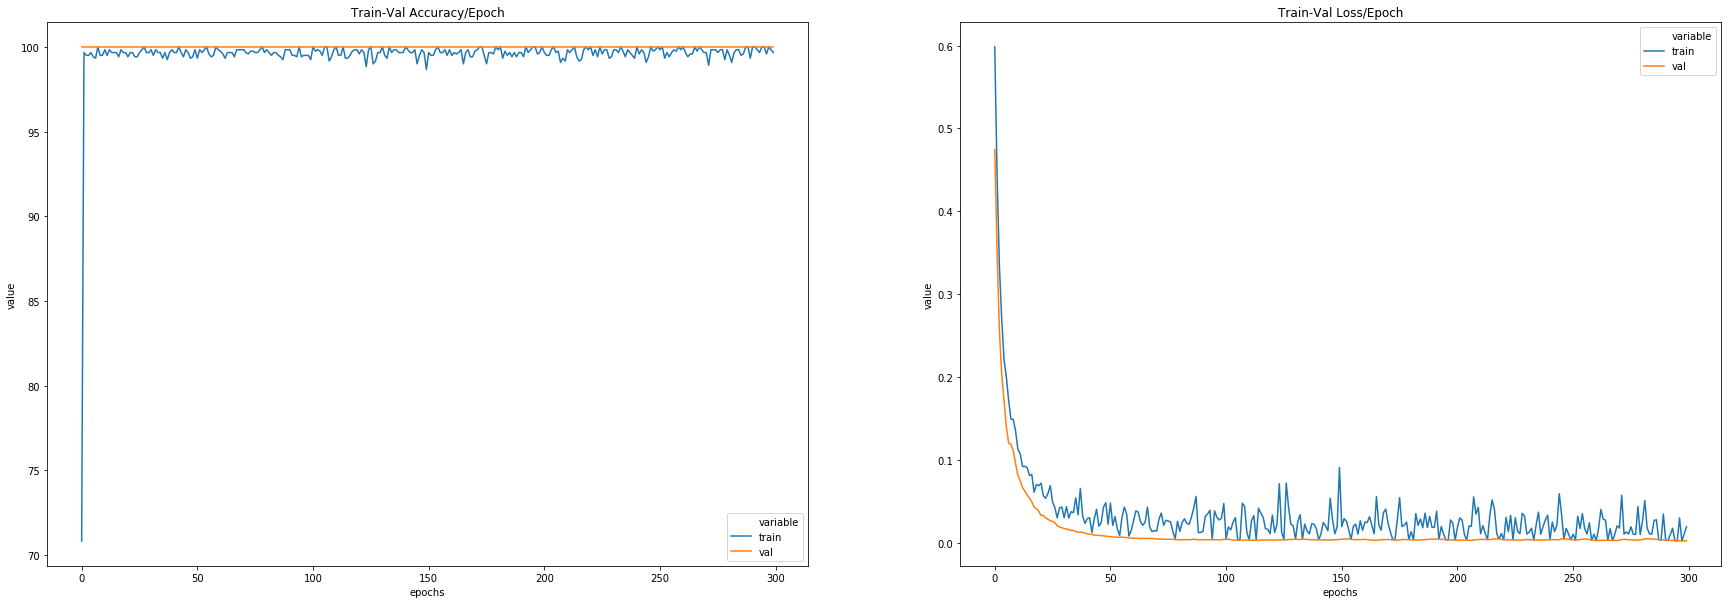

In [111]:
train_val_acc_df = pd.DataFrame.from_dict(accuracy_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(30,10))
sns.lineplot(data=train_val_acc_df, x = "epochs", y="value", hue="variable",  ax=axes[0]).set_title('Train-Val Accuracy/Epoch')
sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable", ax=axes[1]).set_title('Train-Val Loss/Epoch')

In [112]:
y_pred_list = [a.squeeze().tolist() for a in y_pred_list]


In [113]:
print(classification_report(y_test, y_pred_list, target_names=["0", "1"]))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       204
           1       0.00      0.00      0.00         1

    accuracy                           1.00       205
   macro avg       0.50      0.50      0.50       205
weighted avg       0.99      1.00      0.99       205



/Users/evgenysaurov/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
